# What are the most demanded skills for the top 3 most popular data roles?

#### Methodology
1. Clean-up skill column
2. Calculate skill count based on `job_title_short`
3. Calculate skill percentage
4. Plot final findings

## Import Libraries and Data

In [1]:
# Importing Libraries
import ast
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt  

#ignore warnings if any occur
import warnings
warnings.filterwarnings('ignore')

# Loading Data
df= pd.read_csv(r"C:\Users\DELL\Downloads\data_jobs.csv")

# Data Cleanup
df['job_posted_date'] = pd.to_datetime(df['job_posted_date'])
df['job_skills'] = df['job_skills'].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else x)

## Filter Data for the India

Filter the data for the market of the United States.

In [2]:
df_IND = df[df['job_country'] == 'India']

## Explode Skills

Converts the `job_skills` column from string representations of lists into actual list objects and then expands these lists so each skill appears in its own row. It then displays the `job_title` and `job_skills` columns, allowing us to analyze the distribution of skills across different data job titles.

In [3]:
df_skills = df_IND.explode('job_skills')

df_skills[['job_title', 'job_skills']]

,job_title,job_skills
16,Big Data Engineer,powershell
16,Big Data Engineer,python
16,Big Data Engineer,sql
16,Big Data Engineer,mysql
16,Big Data Engineer,sql server
...,...,...
785716,Application Support Analyst,c#
785716,Application Support Analyst,sql
785718,Senior Performance QA Analyst,NaN
785740,AWS System Analyst,aws


## Count Skills per Job Title

Groups DataFrame by `job_skills` and `job_title_short`, counting the occurrences of each skill within each job title. Then resets the index of the Series to turn it back into a DataFrame and renames the series holding the count to 'count'. The final DataFrame, `df_skills_count`, shows the frequency of each skill with each job title.

In [4]:
# Group by job_skills and job_title_short and count the number of occurrences
df_skills_count = df_skills.groupby(['job_skills', 'job_title_short']).size()

# Name the count column as count
df_skills_count = df_skills_count.reset_index(name='skill_count')

# Sort the values by skill_count in descending order
df_skills_count.sort_values(by='skill_count', ascending=False, inplace=True)

df_skills_count

,job_skills,job_title_short,skill_count
1374,sql,Data Engineer,12993
1088,python,Data Engineer,11568
1089,python,Data Scientist,9248
1327,spark,Data Engineer,7157
103,aws,Data Engineer,6993
...,...,...,...
389,esquisse,Data Scientist,1
887,node.js,Senior Data Analyst,1
753,matlab,Cloud Engineer,1
411,fastapi,Cloud Engineer,1


## Create List of Top 3 Roles

#### Focus: Data Analysts, Data Engineers, and Data Scientists

Filter the job titles based on the most popular.

In [5]:
job_titles = df_skills_count['job_title_short'].unique().tolist()

job_titles = sorted(job_titles[:3])

job_titles

['Data Analyst', 'Data Engineer', 'Data Scientist']

## Plot Skill Counts

Creates a stacked horizontal bar chart for the top 5 skills for Top 3 roles, displaying the frequency of each skill. 

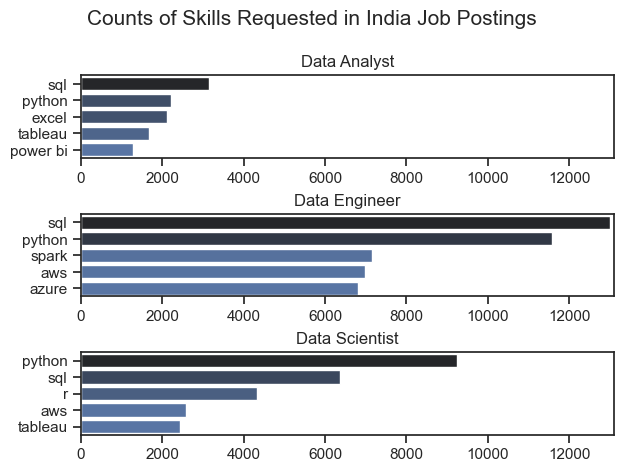

In [12]:
fig, ax = plt.subplots(len(job_titles), 1)

sns.set_theme(style='ticks')

for i, job_title in enumerate(job_titles):
    df_plot = df_skills_count[df_skills_count['job_title_short'] == job_title].head(5)[::-1]
    sns.barplot(data=df_plot, x='skill_count', y='job_skills', ax=ax[i], hue='skill_count', palette='dark:b_r')
    ax[i].set_title(job_title)
    ax[i].invert_yaxis()
    ax[i].set_ylabel('')
    ax[i].set_xlabel('')
    ax[i].get_legend().remove()
    ax[i].set_xlim(0, 13100) # make the scales the same

fig.suptitle('Counts of Skills Requested in India Job Postings', fontsize=15)
fig.tight_layout(h_pad=0.5) # fix the overlap
plt.show()

## Convert Counts to Percentages

#### Focus: Counts don't show what portions of jobs are requesting these skills

So we'll convert the counts into percentages which helps us understand how each job title represents relative to the entire dataset. 

Before we can calculate the percentages we need the total counts for the jobs posted by job title. Calculate the frequency of each job title using the `value_counts()` method on the `job_title_short` column. Then reset the index to transform the Series into a DataFrame and renames the columns to `job_title_short` and `total`. The DataFrame `df_job_title_count` now holds a list of job titles alongside their total occurrences.

In [13]:
# Use original df to get the count of job titles
df_job_title_count = df_IND['job_title_short'].value_counts().reset_index(name='jobs_total')

df_job_title_count

,job_title_short,jobs_total
0,Data Engineer,19062
1,Data Scientist,13279
2,Data Analyst,6121
3,Senior Data Engineer,4353
4,Senior Data Scientist,2486
5,Business Analyst,1887
6,Software Engineer,1795
7,Senior Data Analyst,1083
8,Machine Learning Engineer,671
9,Cloud Engineer,351


Then we calculate the percentages. First merge `df_skills_count` and `df_job_title_count`, based on the 'job_title_short' column, ensuring each skill count is associated with the total number of job postings for that title. Then calculate the percentage of each skill within its job title by dividing the skill count by the total job postings and multiplying by 100, adding this new data as a 'percentage' column. 

In [14]:
df_skills_perc = pd.merge(df_skills_count, df_job_title_count, on='job_title_short', how='left')

df_skills_perc['skill_percent'] = (df_skills_perc['skill_count'] / df_skills_perc['jobs_total']) * 100

df_skills_perc

,job_skills,job_title_short,skill_count,jobs_total,skill_percent
0,sql,Data Engineer,12993,19062,68.161788
1,python,Data Engineer,11568,19062,60.686182
2,python,Data Scientist,9248,13279,69.643798
3,spark,Data Engineer,7157,19062,37.545903
4,aws,Data Engineer,6993,19062,36.685552
...,...,...,...,...,...
1684,esquisse,Data Scientist,1,13279,0.007531
1685,node.js,Senior Data Analyst,1,1083,0.092336
1686,matlab,Cloud Engineer,1,351,0.284900
1687,fastapi,Cloud Engineer,1,351,0.284900


## Plot Percentage Count

Filters and sorts a DataFrame to get the top 5 skills percentages for these top 3 roles. After sorting the skills by descending percentage, reverse the order of these top 5 entries to use in a horizontal bar plot, which by default starts plotting from the bottom.

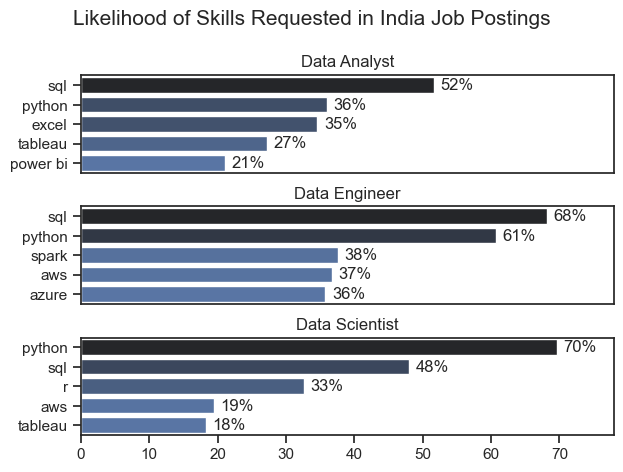

In [15]:
fig, ax = plt.subplots(len(job_titles), 1)


for i, job_title in enumerate(job_titles):
    df_plot = df_skills_perc[df_skills_perc['job_title_short'] == job_title].head(5)
    sns.barplot(data=df_plot, x='skill_percent', y='job_skills', ax=ax[i], hue='skill_count', palette='dark:b_r')
    ax[i].set_title(job_title)
    ax[i].set_ylabel('')
    ax[i].set_xlabel('')
    ax[i].get_legend().remove()
    ax[i].set_xlim(0, 78)
    # remove the x-axis tick labels for better readability
    if i != len(job_titles) - 1:
        ax[i].set_xticks([])

    # label the percentage on the bars
    for n, v in enumerate(df_plot['skill_percent']):
        ax[i].text(v + 1, n, f'{v:.0f}%', va='center')

fig.suptitle('Likelihood of Skills Requested in India Job Postings', fontsize=15)
fig.tight_layout(h_pad=.8)
plt.show()